In [2]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
train = pd.read_csv("Tweet_NFT.csv")
test = pd.read_csv("Tweet_NFT_test.csv")

In [4]:
train.shape

(127451, 4)

In [5]:
train.head()

,id,tweet_text,tweet_created_at,tweet_intent
0,1212762.0,@crypto_brody @eCoLoGy1990 @MoonrunnersNFT @It...,2022-08-06T16:56:36.000Z,Community
1,1212763.0,Need Sick Character artâ“#art #artist #Artist...,2022-08-06T16:56:36.000Z,Giveaway
2,1212765.0,@The_Hulk_NFT @INagotchiNFT @Tesla @killabears...,2022-08-06T16:56:35.000Z,Appreciation
3,1212766.0,@CryptoBatzNFT @DarekBTW The first project in ...,2022-08-06T16:56:35.000Z,Community
4,1212767.0,@sashadysonn The first project in crypto with ...,2022-08-06T16:56:34.000Z,Community


C:\Users\rahul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


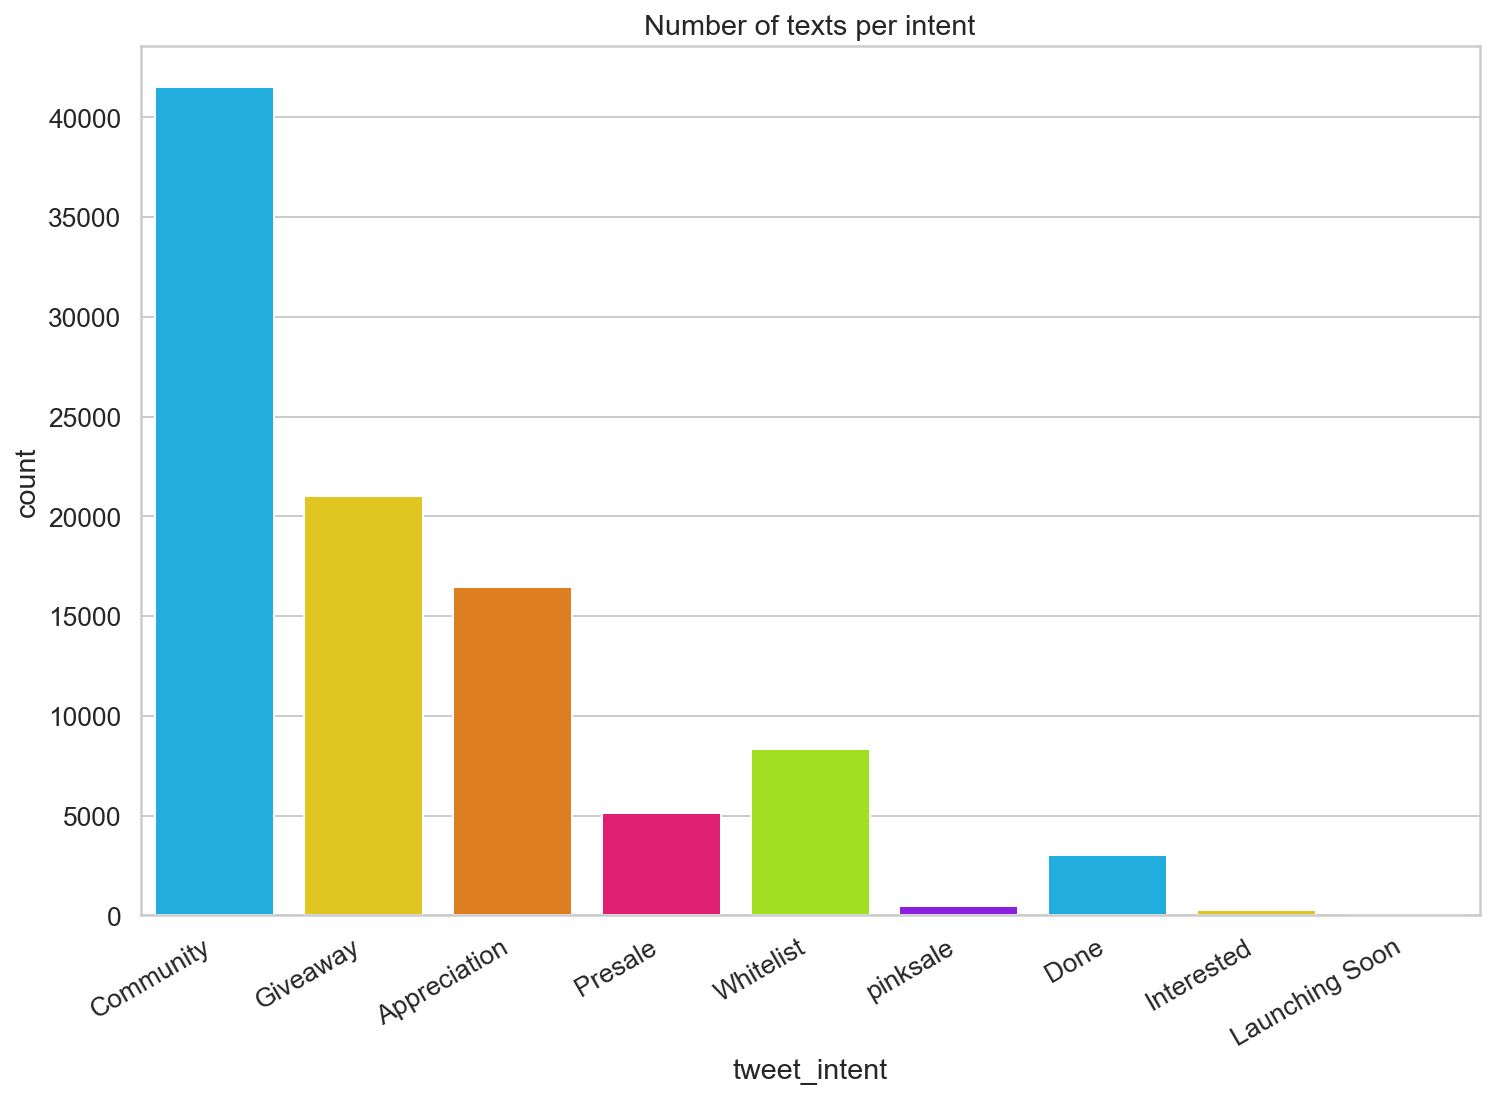

In [6]:
chart = sns.countplot(train.tweet_intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [7]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [8]:
os.makedirs("model", exist_ok=True) #model folder should exist under Intent_Analysis folder

In [9]:
!mv uncased_L-12_H-768_A-12/ model

In [10]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [11]:
class IntentDetectionData:
  DATA_COLUMN = "tweet_text"
  LABEL_COLUMN = "tweet_intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      tweet_text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(tweet_text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [12]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [13]:
def create_model(max_seq_len, bert_ckpt_file):
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
  input_ids = keras.layers.Input(
    shape=(max_seq_len, ),
    dtype='int32',
    name="input_ids"
  )
  bert_output = bert(input_ids)
  print("bert shape", bert_output.shape)
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(
    units=len(classes),
    activation="softmax"
  )(logits)
  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))
  load_stock_weights(bert, bert_ckpt_file)
  return model

In [16]:
classes = train.tweet_intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

96364it [01:35, 1006.72it/s]


ValueError: Unsupported string type: <class 'float'>

In [ ]:
data.train_x.shape

In [ ]:
data.train_x[0]

In [ ]:
data.max_seq_len

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)